# Model 3 - CNN+RNN using both geo-spatial and kinematic features

In [1]:
# Your code goes here
from google.colab import drive
# This will prompt for authorization.

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install datashader

     |████████████████████████████████| 15.5MB 203kB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 1.6MB 51.4MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 675kB 47.5MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp36-none-any.whl size=59430 sha256=9658d8eda23bf4ea951fb000a8cedf922a1af44b6130ce26e2aa40f10b5d1a6e
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4042 sha256=3b4ca49730e97afadd3039a1bf7d1c6a26b81a6917bc5a25472f8dab47a535df
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=8c585b35d37a756af015f964cd93324d37c58f01f4bc3e7e273

In [397]:
#%load_ext autoreload
#%autoreload 2

import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

%cd /content/drive/My\ Drive/Colab\ Notebooks/DataLoaderForStudents/src
from data_utils_conda import *
clear_output(wait=False)

### Load train, validation and test data

In [343]:
user_train, user_val, user_test = train, val, test = train_test_data_split(Random=True)

In [398]:
print(user_train)
print(user_val)
print(user_test)

[9, 0, 3, 8, 1, 5, 6, 2]
[10]
[4, 7, 11]


### Load Kinematik features and Labels

In [345]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/DataLoaderForStudents
dataset = decompress_pickle('./Pickle/dataSet.pbz2')
#dataset = pd.read_pickle('Pickle/dataSet.pbz2',compression='bz2')

/content/drive/My Drive/Colab Notebooks/DataLoaderForStudents


**Remove trips labelled as default**

For each user we remove the entire day of observations if there is a default value. 

In [346]:
WithDefault = 0

Total = 0

for id in dataset.user.unique():
    WithDefault += dataset['ts'][(dataset.user == id) & (dataset.labelM == 4)].dt.date.nunique()
    Total += dataset['ts'][(dataset.user == id)].dt.date.nunique()

print("Days with a default value:", WithDefault, "Days in total:", Total, "Days left in dataset:", Total-WithDefault)

Days with a default value: 113 Days in total: 170 Days left in dataset: 57


In [347]:
#listOfFilteredDfs = [dataset[(dataset.user == id) & (dataset.ts.dt.date == dd)] for dd in [dataset['ts'][(dataset.user== id) & (dataset.labelM != 4)].dt.date.unique()] for id in dataset.user.unique()]
df = pd.DataFrame(columns = ['user', 'ts', 'image_ix', 'label2', 'labelP', 'labelM', 'delta_t',
       'delta_d', 'bearing', 'speed', 'tod', 'segment_id', 'segment_ix',
       'segment_point_count'])
allDays = dataset['ts'].dt.date.unique()

for id in dataset.user.unique():
    defaultDays = dataset['ts'][(dataset.user== id) & (dataset.labelM == 4)].dt.date.unique()
    for dd in (list(set(allDays) - set(defaultDays))):
        df = pd.concat([df, dataset[(dataset.user == id) & (dataset.ts.dt.date == dd)]])

dataset = df.copy()

## Handling labels 

In [348]:
def toString(x):
    x = str(x)
    return x

In [349]:
dataset['label'] = dataset['label2'].apply(lambda x: toString(x)) + dataset['labelP'].apply(lambda x: toString(x)) + dataset['labelM'].apply(lambda x: toString(x))

In [350]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(dataset['label'].unique())
dataset['label_new'] = le.transform(dataset['label'])

In [351]:
dataset.head()

,user,ts,image_ix,label2,labelP,labelM,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count,label,label_new
30318,2,2018-07-07 00:05:34+00:00,12713,1,8,0,716.0,0.011132,0.000000,0.000016,0,2208,0,1,180,9
30319,2,2018-07-07 00:17:34+00:00,12714,1,8,0,720.0,0.000000,0.000000,0.000000,0,2209,0,1,180,9
30320,2,2018-07-07 00:23:38+00:00,12715,1,8,0,364.0,0.389873,-2.723066,0.001071,0,2210,0,1,180,9
30321,2,2018-07-07 00:35:34+00:00,12716,1,8,0,716.0,0.000000,0.000000,0.000000,0,2211,0,1,180,9
30322,2,2018-07-07 00:41:35+00:00,12717,1,8,0,361.0,0.000000,0.000000,0.000000,0,2212,0,1,180,9


**One hot encoding**

In [352]:
dataset1 = dataset.copy()
dataset1 = pd.get_dummies(dataset,columns=['tod'])

In [353]:
dataset1 = dataset1.drop(['label2','labelM','labelP'],1)

In [354]:
dataset1.head()

,user,ts,image_ix,delta_t,delta_d,bearing,speed,segment_id,segment_ix,segment_point_count,label,label_new,tod_0,tod_1,tod_2,tod_3,tod_4
30318,2,2018-07-07 00:05:34+00:00,12713,716.0,0.011132,0.000000,0.000016,2208,0,1,180,9,1,0,0,0,0
30319,2,2018-07-07 00:17:34+00:00,12714,720.0,0.000000,0.000000,0.000000,2209,0,1,180,9,1,0,0,0,0
30320,2,2018-07-07 00:23:38+00:00,12715,364.0,0.389873,-2.723066,0.001071,2210,0,1,180,9,1,0,0,0,0
30321,2,2018-07-07 00:35:34+00:00,12716,716.0,0.000000,0.000000,0.000000,2211,0,1,180,9,1,0,0,0,0
30322,2,2018-07-07 00:41:35+00:00,12717,361.0,0.000000,0.000000,0.000000,2212,0,1,180,9,1,0,0,0,0


In [355]:
weights = 1. / dataset1.label_new.value_counts().sort_index().values

**Standardize data**

In [356]:
dataset1['delta_t'] = (dataset1['delta_t']-dataset1['delta_t'].mean())/dataset1['delta_t'].std()
dataset1['delta_d'] = (dataset1['delta_d']-dataset1['delta_d'].mean())/dataset1['delta_d'].std()
dataset1['bearing'] = (dataset1['bearing']-dataset1['bearing'].mean())/dataset1['bearing'].std()

**Split in train, test and validation sets**

####Split based on days

In [357]:
Days = dataset1['ts'].dt.date.unique()
len(Days)

35

In [358]:
from sklearn.model_selection import train_test_split

dummy_features = Days
dummy_target = np.zeros(len(Days))

x_train, x_test, y_train, y_test = train_test_split(dummy_features, dummy_target, train_size=0.7, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42)

In [359]:
print(len(x_train),len(x_val),len(x_test))

19 5 11


In [360]:
data_train = pd.concat([dataset1[(dataset1.ts.dt.date==tr)] for tr in x_train]).reset_index(drop=True)
data_val = pd.concat([dataset1[(dataset1.ts.dt.date==va)] for va in x_val]).reset_index(drop=True)
data_test = pd.concat([dataset1[(dataset1.ts.dt.date==te)] for te in x_test]).reset_index(drop=True)
print(len(data_train),len(data_val),len(data_test))

127590 26824 31444


In [361]:
#weights = 1. / data_train.label_new.value_counts().sort_index().values
weights = [1/(38+1973+60), 1/2099, 0, 1/31, 1/(9830+21007+2108), 1/60, 1/5, 1/1194, 1/6, 1/(44536+64006+27), 1/(450+338+52), 1/(4315+4509+637), 1/(1118+1528+1633), 1/58]

###Split based on users

In [137]:
data_train = pd.concat([dataset1[(dataset1.user==tr)] for tr in user_train]).reset_index(drop=True)
data_val = pd.concat([dataset1[(dataset1.user==va)] for va in user_val]).reset_index(drop=True)
data_test = pd.concat([dataset1[(dataset1.user==te)] for te in user_test]).reset_index(drop=True)

In [138]:
data_train.head()

,user,ts,image_ix,delta_t,delta_d,bearing,speed,segment_id,segment_ix,segment_point_count,label,label_new,tod_0,tod_1,tod_2,tod_3,tod_4
0,9,2018-06-30 00:00:00+00:00,317345,-0.006813,-0.05501,0.007861,0.0,2513,310,929,180,9,1,0,0,0,0
1,9,2018-06-30 00:00:01+00:00,317346,-0.006813,-0.05501,0.007861,0.0,2513,311,929,180,9,1,0,0,0,0
2,9,2018-06-30 00:00:02+00:00,317347,-0.006813,-0.05501,0.007861,0.0,2513,312,929,180,9,1,0,0,0,0
3,9,2018-06-30 00:00:03+00:00,317348,-0.006813,-0.05501,0.007861,0.0,2513,313,929,180,9,1,0,0,0,0
4,9,2018-06-30 00:00:04+00:00,317349,-0.006813,-0.05501,0.007861,0.0,2513,314,929,180,9,1,0,0,0,0


In [139]:
print(dataset1.label_new.unique())

[ 9 10 11  6  8  4  0 12  1  5  7  3  2 13]


### Set or modify cut off parameters (for cleansing noise)

In [362]:
seq_cutoff_speed = 45
seq_cutoff_time = 60
filter_seq = 25
label = 'label_new'
input_features = ['delta_d','delta_t','bearing','tod_0','tod_1','tod_2','tod_3','tod_4','label_new']


In [363]:
dataset1.columns

Index(['user', 'ts', 'image_ix', 'delta_t', 'delta_d', 'bearing', 'speed',
       'segment_id', 'segment_ix', 'segment_point_count', 'label', 'label_new',
       'tod_0', 'tod_1', 'tod_2', 'tod_3', 'tod_4'],
      dtype='object')

#### Define Image Tensor Dataset

We implement our own Tensor Dataset in order to be able to do fast lookup of sequences and images.

In [364]:
class ImageTensorDataset(torch.utils.data.Dataset):

    def __init__(self, df,filter_seq=filter_seq, label=label):
        self.seq = np.stack([np.roll(df[input_features].values, i, axis = 0) for i in range(filter_seq, -1, -1)], axis = 1)
        self.seq = self.seq[df['segment_ix'] >= filter_seq]
        print(self.seq.shape)
        self.labels = df[df['segment_ix'] >= filter_seq][label].values
        print(self.labels.shape)
        self.user_id = df[df['segment_ix'] >= filter_seq]['user'].values
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, key):
        return self.seq[key], self.labels[key]

**Make training, test and validation set into Tensor dataset**

In [365]:
weights

[0.0004828585224529213,
 0.0004764173415912339,
 0,
 0.03225806451612903,
 3.0353619669145544e-05,
 0.016666666666666666,
 0.2,
 0.0008375209380234506,
 0.16666666666666666,
 9.210732345328777e-06,
 0.0011904761904761906,
 0.00010569707219110031,
 0.00023369946249123628,
 0.017241379310344827]

In [366]:
#class_sample_count = data_train.label_new.value_counts().sort_index().values
#weight = (1. / class_sample_count)**2
#weight[8] = 10
#samples_weight = np.array([weight[t] if t<6 else weight[t-1] if t<9 else weight[t-3] if t==11 else weight[t-4] for t in y_classes_Train.values])
#samples_weight = torch.from_numpy(samples_weight)
#samples_weigth = samples_weight.double()
#sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

In [367]:
demo_dataset = ImageTensorDataset(data_train)
train_loader =  torch.utils.data.DataLoader(demo_dataset, batch_size=64*2, shuffle=True)#, sampler=sampler)
demo_dataset = ImageTensorDataset(data_test)
test_loader = torch.utils.data.DataLoader(demo_dataset, batch_size=64*2, shuffle=True)
demo_dataset = ImageTensorDataset(data_val)
val_loader = torch.utils.data.DataLoader(demo_dataset, batch_size=64*2, shuffle=True)

(113971, 26, 9)
(113971,)
(26106, 26, 9)
(26106,)
(21541, 26, 9)
(21541,)


In [368]:
#demo_dataset = ImageTensorDataset(data_train)
#wholeTrainDataset = torch.utils.data.DataLoader(demo_dataset, batch_size=len(demo_dataset), shuffle=False)
#wholeTrainDataset

In [369]:
#y_classes = []
#for feat, y in wholeTrainDataset:
#    y_classes.append(y)
#    ;
#y_classes_Train = pd.DataFrame(data=np.transpose(np.concatenate(y_classes, axis=0)),columns=['class_test'])
#y_classes_Train.value_counts().sort_index()

In [370]:
y_classes = []
for feat, y in test_loader:
    y_classes.append(y)
    ;
y_classes_new = pd.DataFrame(data=np.transpose(np.concatenate(y_classes, axis=0)),columns=['class_test'])
y_classes_new.value_counts()

class_test
9             13673
4              7829
12             2436
11             1804
10              295
0                38
3                31
dtype: int64

In [371]:
y_classes = []
for feat, y in train_loader:
    y_classes.append(y)
    ;
y_classes_new = pd.DataFrame(data=np.transpose(np.concatenate(y_classes, axis=0)),columns=['class_train'])
y_classes_new.value_counts()

class_train
9              88075
4              15584
11              4807
0               2033
12              1803
7               1194
10               417
13                58
dtype: int64

In [372]:
y_classes = []
for feat, y in val_loader:
    y_classes.append(y)
    ;
y_classes_new = pd.DataFrame(data=np.transpose(np.concatenate(y_classes, axis=0)),columns=['class_val'])
y_classes_new.value_counts()

class_val
4            9532
9            6821
11           2850
1            2099
10            128
5              60
12             40
8               6
6               5
dtype: int64

In [373]:
torch_tensor = torch.tensor(y_classes_new['class_val'].values)

In [374]:
torch_tensor.shape

torch.Size([21541])

**Building RNN model**

In [542]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        # YOUR CODE HERE!
        self.lstm = nn.LSTM(input_size=9,
                         hidden_size=200,
                         num_layers=5,
                         bidirectional=False,
                         dropout = 0.5) # for regularization
        
        # Output layer
        self.l_out = nn.Linear(in_features=200*26,
                            out_features=14,
                            bias=False)
        
    def forward(self, x):
        #x = F.relu(x) # activation function. There are already a lot of activation function in the LSTM... sigmoid and tanh. 
                            
        # RNN returns output and last hidden state
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        #x = x.view(-1, self.lstm.hidden_size)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2])
        
        #x = F.softmax(x)
        # Output layer
        x = self.l_out(x)
        x = F.softmax(x,dim=1)
        
        return x

net = MyRecurrentNet()
print(net)

MyRecurrentNet(
  (lstm): LSTM(9, 200, num_layers=5, dropout=0.5)
  (l_out): Linear(in_features=5200, out_features=14, bias=False)
)


**Training loop**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Training going on... epoch:  0
Epoch 0, training loss: 2.5407139832189456, validation loss: 2.7215549169912845
Training going on... epoch:  1
Epoch 1, training loss: 2.5343426785752694, validation loss: 2.7148939011365
Training going on... epoch:  2
Epoch 2, training loss: 2.5342256356570054, validation loss: 2.7132921359948154
Training going on... epoch:  3
Epoch 3, training loss: 2.533824268548711, validation loss: 2.7201107126721262
Training going on... epoch:  4
Epoch 4, training loss: 2.533966396794175, validation loss: 2.717964989193798
Training going on... epoch:  5
Epoch 5, training loss: 2.5342653059932654, validation loss: 2.713486702484492
Training going on... epoch:  6
Epoch 6, training loss: 2.533577409256187, validation loss: 2.7189518742307404
Training going on... epoch:  7
Epoch 7, training loss: 2.533385711353101, validation loss: 2.716175550539818
Training going on... epoch:  8
Epoch 8, training loss: 2.533821702940028, validation loss: 2.715125783660708
Training goin

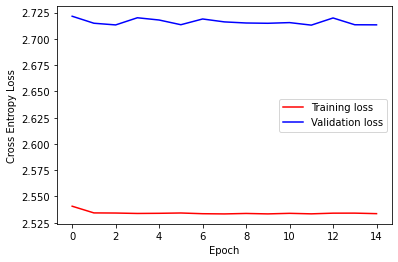

In [544]:
# Hyper-parameters
num_epochs = 15
#net = net.double()
net = net.cuda()

# Initialize a new network
net = MyRecurrentNet()

# Define a loss function and optimizer for this problem
# YOUR CODE HERE!
import torch.optim as optim
weights = torch.tensor(weights).cuda()
weights = weights.float()
criterion =nn.CrossEntropyLoss(weight=weights).cuda() # Classification  
#criterion =nn.CrossEntropyLoss().cuda() # Classification  
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-4)
#optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum = 0.01) 

# Track loss
training_loss, validation_loss = [], []
# Track accuracy
val_targ, validation_pred = [], []
validation_acc = []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.cuda().train()
    
    # For each sentence in training set
    print("Training going on... epoch: ", i)
    for inputs, targets in train_loader:
        
        # Forward pass
        inputs = inputs.cuda()
        outputs = net(inputs.float())
        #outputs = net(inputs.double)
        
        targets = targets.type(torch.LongTensor)
        
        # Compute loss
        targets = targets.cuda()
        loss = criterion(outputs,targets)
        
        # Backward pass
        # zero grad, backward, step...
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.cpu().detach().numpy()
        
    
    net.cuda().eval()
        
    # For each sentence in validation set
    for inputs, targets in val_loader:
        
        #print(targets.shape)
        # Forward pass
        #outputs = net(inputs.double())
        inputs = inputs.cuda()
        outputs = net(inputs.float())
        
        # Compute accuracy
        #preds = torch.max(outputs, 1)[1]
        #validation_pred.append(preds.cpu().detach().numpy())
        
        # Compute loss
        targets = targets.type(torch.LongTensor)
        targets = targets.cuda()
        loss = criterion(outputs,targets)

        # Validation targets
        #val_targ.append(targets.cpu().data.numpy())
        
        # Update loss
        epoch_validation_loss += loss.cpu().detach().numpy()
    

    # Save loss for plot
    training_loss.append(epoch_training_loss/len(train_loader))
    validation_loss.append(epoch_validation_loss/len(val_loader))
    #validation_pred = list(np.concatenate(validation_pred,axis=0))
    #val_targ = list(np.concatenate(val_targ,axis=0))
    #val_acc = accuracy_score(val_targ, validation_pred)
    #validation_acc.append(val_acc)

    # Print loss every 10 epochs
    #if i % 10 == 0:
    print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('Cross Entropy Loss')
plt.show()

#plt.figure()
#plt.plot(epoch, validation_acc, 'k')
#plt.legend()
#plt.xlabel('Epoch'), plt.ylabel('Cross Entropy Loss')
#plt.title('Validation accuracy')
#plt.show()

**Testing the model**

In [531]:
inputs_test, targets_test = next(iter(test_loader))

In [532]:
test_output = net.forward(inputs_test.float().cuda())

In [533]:
test_output[0]

tensor([0.5141, 0.0066, 0.0066, 0.0066, 0.0080, 0.0066, 0.0066, 0.2031, 0.0066,
        0.2104, 0.0062, 0.0076, 0.0060, 0.0050], device='cuda:0',
       grad_fn=<SelectBackward>)

Test from week 4 where softmax is used on the output layer

In [534]:
_, predicted = torch.max(test_output.data, 1)

In [535]:
predicted

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [536]:
test = F.sigmoid(test_output)
test = test.data.cpu().numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [537]:
import tensorflow
result = tensorflow.one_hot(tensorflow.argmax(test, axis = 1), on_value=1, depth = 23)

In [538]:
result[0]

<tf.Tensor: shape=(23,), dtype=int32, numpy=
array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)>

In [539]:
np.set_printoptions(threshold=sys.maxsize)
print('\nTarget :')
print(targets_test.data.numpy())

print('\nPredicted :')
print(predicted.cpu().data.numpy())


Target :
[ 4  4 11  4 11  9  9  9  9  9 12  4  4  9 12  9  9 12  9 11  4  9  9  9
 12 11  4  9  4 12 12  9  4  4  9  4 11  9  4  4  4  4  4  4  9  9  9 11
  9  4  9  9  4  4 12  4  9  9  4  9  9  9  4  9 11  9 12  9  9 12  4 11
  9  9 12 12  4  4  4  9  9  4  9  4  4  9  9 12  4  9  9  4 12 11  9  9
  4  4  9  9  4  9  9  4  9  4  9  4  9  9 12  9  9 11  9  4 11  9  9  9
  9  4  4  4  9  9 10  4]

Predicted :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [540]:
from sklearn.metrics import accuracy_score
test_acc_cur = accuracy_score(targets_test.data.numpy(), predicted.cpu().data.numpy())

In [541]:
test_acc_cur

0.0

In [485]:
correct = 0
total = 0
#print(type(targets_collected))
predictions_collected, targets_collected = [], []

for inputs_test, targets_test in test_loader:
    test_output = net.forward(inputs_test.cuda().float())
    _, predicted = torch.max(test_output, 1)
    targets_collected.append(targets_test.detach().numpy())
    predictions_collected.append(predicted.cpu().detach().numpy())
    total += targets_test.size(0)
    correct += (predicted.cpu() == targets_test).sum()
    

print('Accuracy of the network on the test set: {:4.2f} %'.format(100 * correct.true_divide(total)))

Accuracy of the network on the test set: 52.37 %


In [455]:
targets_collected[:3]

[array([ 4,  9, 12,  9,  4,  4,  4,  9,  9,  4,  4,  9,  9,  4, 11, 11,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 11,  4,  4,  9,  9, 12,  9,
         9,  9,  9,  9,  9,  9,  4,  9,  4, 11,  9,  4,  9,  4,  4,  9,  9,
         9,  9,  4,  9,  9,  9,  4,  4,  9,  9,  4,  4,  4,  4,  9,  4,  4,
         9,  9, 12,  9,  9,  9,  4,  4, 11,  9,  9, 10, 12, 12,  4,  9,  9,
         9, 11, 11,  4,  9,  9,  4,  9,  4,  4,  9,  9,  4,  9,  9,  9,  9,
         9,  9,  4,  9,  9,  9,  9,  9,  4,  9,  9,  4,  4,  9, 12,  4,  9,
         9,  9,  9,  9,  9,  4,  9,  4, 11]),
 array([ 9, 12,  4,  9,  9,  9,  4, 12,  9,  4,  9, 12,  9,  9,  4,  9,  9,
         4, 11,  9,  9,  9,  4,  4,  9, 12,  9,  9,  9, 11,  4,  9,  9,  9,
        11, 10,  4,  9,  9,  9,  4,  9,  4,  4,  9,  9,  4,  4,  4,  4,  9,
         9,  9,  4,  4,  9,  9,  4,  9, 12,  9,  9,  9, 11,  4,  4,  9,  9,
        11,  4,  9,  4,  4,  4, 12, 11,  9,  4,  9,  9, 11,  9,  9,  9,  9,
         4, 12, 11,  9,  9,  4, 12,  4,  9

In [456]:
predictions_collected[:3]

[array([4, 9, 9, 9, 0, 7, 7, 9, 9, 0, 7, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 0, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 0, 9,
        9, 0, 9, 0, 7, 9, 9, 9, 9, 7, 9, 9, 9, 0, 7, 9, 9, 0, 7, 7, 7, 9,
        7, 7, 9, 9, 9, 9, 9, 9, 0, 0, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 9,
        7, 9, 9, 0, 9, 7, 7, 9, 9, 0, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9,
        0, 9, 9, 0, 7, 9, 9, 7, 9, 9, 9, 9, 9, 9, 0, 9, 7, 9]),
 array([9, 9, 7, 9, 9, 9, 0, 9, 9, 0, 9, 9, 9, 9, 7, 9, 9, 0, 9, 9, 9, 9,
        0, 7, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 9, 7, 9, 9, 9, 0, 9, 0, 7,
        9, 9, 7, 7, 7, 7, 9, 9, 9, 0, 7, 9, 9, 0, 9, 9, 9, 9, 9, 9, 7, 7,
        9, 9, 9, 0, 9, 7, 7, 7, 9, 7, 9, 7, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9,
        9, 9, 0, 9, 0, 9, 0, 7, 7, 7, 9, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 0, 7, 9, 9, 0, 9, 9, 0, 9, 9, 0, 9, 9, 9, 9, 9]),
 array([9, 9, 7, 9, 9, 0, 9, 0, 7, 9, 9, 9, 7, 9, 9, 9, 9, 0, 9, 9, 0, 9,
        9, 0, 9, 9, 7, 7, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 0,

In [457]:
predictions_collected = np.concatenate( predictions_collected, axis=0 )

In [458]:
targets_collected = np.concatenate(targets_collected,axis=0)

In [459]:
predictions_collected.shape

(26106,)

Text(0.5, 1.0, 'Confusion matrix')

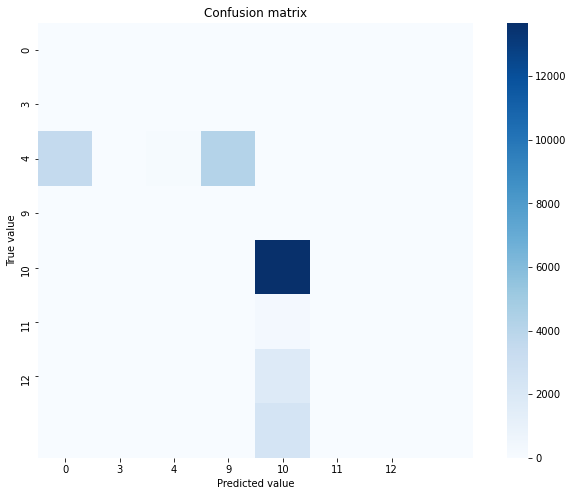

In [460]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#rcParams['figure.figsize'] = 12, 8
plt.figure(figsize=(12,8))
mat = confusion_matrix(targets_collected, predictions_collected)
sns.heatmap(mat, square=True, annot=False, cbar=True,fmt='g',cmap='Blues',xticklabels=np.sort(np.unique(targets_collected)),yticklabels=np.sort(np.unique(targets_collected)))
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title('Confusion matrix')

In [440]:
classes = range(23)
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))
percentage = np.zeros(len(classes))

net.eval()
for inputs_test, targets_test in test_loader:
    test_output = net.forward(inputs_test.cuda().float())
    _, predicted = torch.max(test_output, 1)
    c = (predicted == targets_test.cuda()).squeeze()
    
    for i in range(len(c)):
        label = targets_test[i]
        class_correct[label] += c[i].cpu().numpy()
        class_total[label] += 1
    
    for i in range(len(classes)):
        if class_total[i] != 0:
            percentage[i] = 100 * class_correct[i] / class_total[i]
        else:
            percentage[i] = 100.01
            
for i in range(len(classes)):
    print('Accuracy of {:5d} : {:5.2f} % : {:5.2f}'.format(
        classes[i], percentage[i], class_total[i]))

Accuracy of     0 : 100.00 % : 38.00
Accuracy of     1 : 100.01 % :  0.00
Accuracy of     2 : 100.01 % :  0.00
Accuracy of     3 :  0.00 % : 31.00
Accuracy of     4 : 99.67 % : 7829.00
Accuracy of     5 : 100.01 % :  0.00
Accuracy of     6 : 100.01 % :  0.00
Accuracy of     7 : 100.01 % :  0.00
Accuracy of     8 : 100.01 % :  0.00
Accuracy of     9 : 100.00 % : 13673.00
Accuracy of    10 :  0.00 % : 295.00
Accuracy of    11 :  0.00 % : 1804.00
Accuracy of    12 :  0.00 % : 2436.00
Accuracy of    13 : 100.01 % :  0.00
Accuracy of    14 : 100.01 % :  0.00
Accuracy of    15 : 100.01 % :  0.00
Accuracy of    16 : 100.01 % :  0.00
Accuracy of    17 : 100.01 % :  0.00
Accuracy of    18 : 100.01 % :  0.00
Accuracy of    19 : 100.01 % :  0.00
Accuracy of    20 : 100.01 % :  0.00
Accuracy of    21 : 100.01 % :  0.00
Accuracy of    22 : 100.01 % :  0.00


In [441]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

def compute_error(y_true, y_pred):
    # Compute the accuracy, F1-score (for each class) and kappa value for the given true and predicted classes
    acc = accuracy_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred,average=None)
    f1_tot = f1_score(y_true,y_pred,average='macro')
    kappa = cohen_kappa_score(y_true,y_pred)
    
    # Return error measures
    return  acc, f1, f1_tot, kappa

acc, f1, f1_tot, kappa = compute_error(targets_collected, predictions_collected)
acc, f1, f1_tot, kappa

(0.8240634336934038,
 array([0.95      , 0.        , 0.99604238, 0.85724138, 0.        ,
        0.        , 0.        ]),
 0.4004691091560965,
 0.6767610034480412)